In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transform
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from torchsummary import summary
%matplotlib inline

In [29]:
torch.__version__

'2.4.1+cu121'

In [2]:
class MLPNet(nn.Module):
  def __init__(self) -> None:
    super(MLPNet,self).__init__()
    self.fc1 = nn.Linear(28*28,500)
    self.fc2 = nn.Linear(500,256)
    self.fc3 = nn.Linear(256,10)


  def forward(self,x):
    x = x.view(-1,28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def name(self):
    return "MLP"

In [3]:
def train_model(dataloader,model,device,optimizer,criterion):
  model.train()
  net_loss = 0
  for inputs,targets in dataloader :
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    pred = model(inputs)
    loss = criterion(pred,targets)
    loss.backward()
    optimizer.step()
    net_loss += loss
    return net_loss/len(dataloader)


In [4]:
def validate_model(dataloader,model,device,criterion):
  net_loss=0
  model.eval()
  with torch.no_grad():
   for inputs,targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    pred = model(inputs)
    loss = criterion(pred,targets)
    net_loss += loss
    return net_loss/len(dataloader)

In [5]:
def test_model(dataloader,model,device,optimizer,criterion):
  net_loss = 0
  model.eval()
  with torch.no_grad():
    for inputs,targets in dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      pred = model(inputs)
      loss = criterion(pred,targets)
      net_loss += loss
      return net_loss/len(dataloader)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = MLPNet()
model = model.to(device)

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Number of total parameters: {total_params}')

Number of total parameters: 523326


In [9]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.adam(model.parameters(),lr=0.1)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
scheduler = ReduceLROnPlateau(optimizer,'min',patience=10)

In [10]:
from posixpath import split
num_workers = 0    #no.oof subprocesses used for data loading
batch_size = 100   #how many samples per batch to load
valid_size = 0.2   #percentage if training set to use as validation

transform = transform.ToTensor()   #coverting data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root = 'data',train=False,download=True,transform=transform)

num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indicies[split:],indicies[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)





Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 118788425.20it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 17126494.25it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 81245860.66it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2793742.30it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
train_dataloader = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_dataloader = DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_dataloader = DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

In [12]:
summary(model,input_size=(1,28,28),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]         392,500
            Linear-2                 [100, 256]         128,256
            Linear-3                  [100, 10]           2,570
Total params: 523,326
Trainable params: 523,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 0.58
Params size (MB): 2.00
Estimated Total Size (MB): 2.88
----------------------------------------------------------------


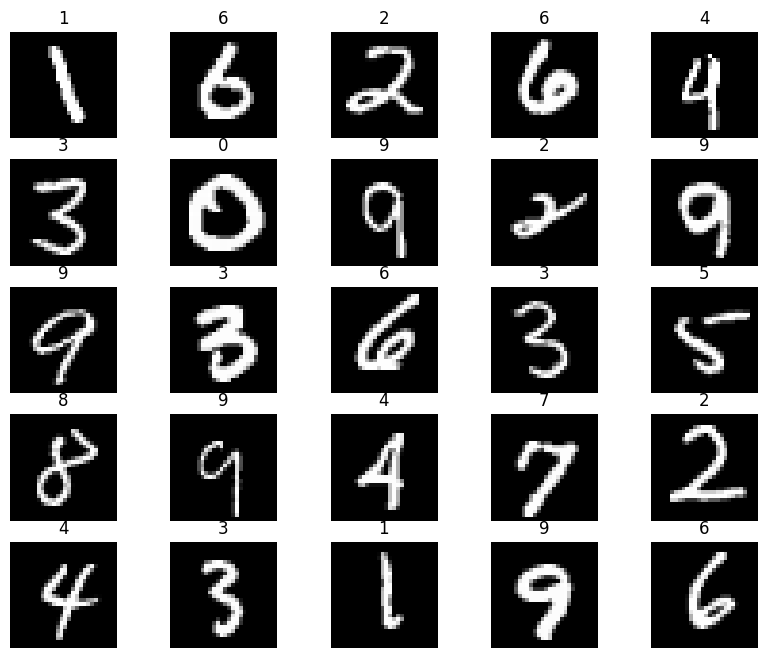

In [13]:
figure = plt.figure(figsize=(10,8))
rows,cols = 5,5
for i in range(1,rows*cols+1):
      sample_idx = torch.randint(len(train_data),size=(1,)).item()
      img,label = train_data[sample_idx]
      figure.add_subplot(rows,cols,i)
      plt.title(label)
      plt.axis('Off')
      plt.imshow(img.squeeze(),cmap='gray')
plt.show()



In [14]:
writer = SummaryWriter("MLPNet")

In [15]:
best_validation_loss = float('inf')

In [16]:
model_paths = r'mlp_weights1.pth'
num_iters = 50

In [17]:
start_time = datetime.now()
for epoch in range(num_iters):
  train_loss = train_model(train_dataloader,model,device,optimizer,criterion)
  writer.add_scalar("Traininf Loss",train_loss,epoch)
  validation_loss = validate_model(valid_dataloader,model,device,criterion)
  if validation_loss<best_validation_loss:
    best_validation_loss = validation_loss
    torch.save(model.state_dict(),model_paths)
  writer.add_scalar("Validation loss:",validation_loss,epoch)
  print("epoch:",epoch,"training loss:",train_loss,"validation loss:",validation_loss)
  scheduler.step(validation_loss)
writer.close()
end_time = datetime.now()
print("Training time:",end_time-start_time)

epoch: 0 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0191)
epoch: 1 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 2 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 3 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 4 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 5 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0191)
epoch: 6 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 7 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 8 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0192)
epoch: 9 training loss: tensor(0.0048, grad_fn=<DivBackward0>) validation loss: tensor(0.0191)
epoch: 10 training loss: tensor(0.0048, grad_fn=<D

In [18]:
model.load_state_dict(torch.load(model_paths))

<ipython-input-18-4c4f6cf0a53e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths))


<All keys matched successfully>

In [19]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

for data,target in test_dataloader:
  output = model(data)
  loss= criterion(output,target)
  test_loss += loss.item()*data.size(0)
  _,pred = torch.max(output,1)
  correct =np.squeeze(pred.eq(target.data.view_as(pred)))
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss:{:.6f}\n'.format(test_loss))
for i in range(20):
  if class_total[i]>0:
    print('Test Accuracy of %5s: %2d (%2d/%2d)'%(
        str(i), 100*class_correct[i]/class_total[i],
        np.sum(class_correct[i]),np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s:N/A (no training examples)' %(classes[i]))

print('\nTest Accuracy(Overall): %2d%% (%2d/%2d)' %(
    100. *np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss:2.300469

Test Accuracy of     0:  2 (27/980)
Test Accuracy of     1:  0 ( 3/1135)
Test Accuracy of     2: 34 (360/1032)
Test Accuracy of     3:  0 ( 0/1010)
Test Accuracy of     4: 55 (546/982)
Test Accuracy of     5:  0 ( 0/892)
Test Accuracy of     6:  2 (24/958)
Test Accuracy of     7:  0 ( 5/1028)
Test Accuracy of     8:  0 ( 0/974)
Test Accuracy of     9:  0 ( 3/1009)


IndexError: list index out of range

In [20]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

with torch.no_grad():  # Disable gradient calculation for evaluation
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)  # Ensure data is on the right device

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        for i in range(data.size(0)):  # Use the batch size dynamically
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Calculate average loss
test_loss = test_loss / len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Print accuracy for each class
for i in range(10):  # Change from 20 to 10
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            int(class_correct[i]), int(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

# Print overall accuracy
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total) if np.sum(class_total) > 0 else 0
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy, int(np.sum(class_correct)), int(np.sum(class_total))))


Test Loss: 2.300469

Test Accuracy of     0:  2 (27/980)
Test Accuracy of     1:  0 ( 3/1135)
Test Accuracy of     2: 34 (360/1032)
Test Accuracy of     3:  0 ( 0/1010)
Test Accuracy of     4: 55 (546/982)
Test Accuracy of     5:  0 ( 0/892)
Test Accuracy of     6:  2 (24/958)
Test Accuracy of     7:  0 ( 5/1028)
Test Accuracy of     8:  0 ( 0/974)
Test Accuracy of     9:  0 ( 3/1009)

Test Accuracy (Overall):  9% (968/10000)
